In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
from sklearn.model_selection import TimeSeriesSplit
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import HeatMap
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

2024-06-29 01:17:49.651668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 01:17:49.651804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 01:17:49.821875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/air-quality-monitoring-in-european-cities/athens_data.csv')
data.head()

,Date,Latitude,Longitude,station_name,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),Temp,Relative Humidity,PM10,PM2.5,NO2,O3,code,id
0,2020-05-01 00:00:00,38.15,23.55,Athens CAMS station 0,1.713115,-0.588855,10.046454,17.083554,0.000035,1.699026,2.244626,12.948856,82.578812,8.101824,6.200135,3.479941,76.28401,ACAMS00,45
1,2020-05-01 00:00:00,37.85,23.75,Athens CAMS station 9,1.960498,-0.937417,10.270286,17.909675,0.000037,1.743299,1.431182,14.011539,78.352731,10.520411,7.836725,17.563843,74.39110,ACAMS09,54
2,2020-05-01 00:00:00,38.15,23.65,Athens CAMS station 1,1.640985,-0.556073,9.700422,16.976489,0.000040,1.642665,2.172998,12.550690,82.840317,8.587352,6.306404,2.892315,74.56569,ACAMS01,46
3,2020-05-01 00:00:00,37.85,23.85,Athens CAMS station 10,2.003834,-0.971722,10.159251,17.993456,0.000036,1.753648,1.582832,14.261641,76.558915,10.917974,8.207660,17.196804,67.90412,ACAMS10,55
4,2020-05-01 00:00:00,37.85,23.95,Athens CAMS station 11,1.954063,-0.912335,9.993532,17.957935,0.000036,1.706804,1.806660,14.179075,76.140202,11.353168,8.217451,15.817172,67.63471,ACAMS11,56


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Sample berdasarkan jam
df = data.copy().groupby(pd.Grouper(freq='h')).first()
df.head()

,Latitude,Longitude,station_name,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),Temp,Relative Humidity,PM10,PM2.5,NO2,O3,code,id
Date,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00,38.150,23.550,Athens CAMS station 0,1.713115,-0.588855,10.046454,17.083554,0.000035,1.699026,2.244626,12.948856,82.578812,8.101824,6.200135,3.479941,76.284010,ACAMS00,45
2020-05-01 01:00:00,38.150,23.850,Athens CAMS station 13,1.618940,-0.525101,9.269925,16.858821,0.000000,1.578908,1.526438,12.280056,81.907699,9.093146,6.974280,5.206758,67.655350,ACAMS13,58
2020-05-01 02:00:00,37.850,23.550,Athens CAMS station 7,2.083532,-1.116353,10.660458,17.721098,0.000000,1.844812,1.361591,13.237882,84.469714,10.023252,6.922194,9.718324,81.920740,ACAMS07,52
2020-05-01 03:00:00,37.988,23.728,ARISTOTELOUS,1.938605,-1.169774,10.596040,17.542913,0.000000,0.946307,0.960796,12.533074,88.028753,164.000000,109.000000,50.000000,2.000000,GR0003A,10
2020-05-01 04:00:00,38.150,23.950,Athens CAMS station 14,1.417891,-0.629551,9.633792,16.267094,0.000000,1.588097,1.108989,11.540909,88.090700,8.519182,5.776556,5.017021,66.808945,ACAMS14,59


# Preprocessing

In [4]:
def preprocess(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df = df.dropna(axis=0)
    return df

In [5]:
df = preprocess(df)
df

,Latitude,Longitude,station_name,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),...,PM2.5,NO2,O3,code,id,year,month,day,hour,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00,38.15000,23.550000,Athens CAMS station 0,1.713115,-0.588855,10.046454,17.083554,0.000035,1.699026,2.244626,...,6.200135,3.479941,76.284010,ACAMS00,45,2020,5,1,0,4
2020-05-01 01:00:00,38.15000,23.850000,Athens CAMS station 13,1.618940,-0.525101,9.269925,16.858821,0.000000,1.578908,1.526438,...,6.974280,5.206758,67.655350,ACAMS13,58,2020,5,1,1,4
2020-05-01 02:00:00,37.85000,23.550000,Athens CAMS station 7,2.083532,-1.116353,10.660458,17.721098,0.000000,1.844812,1.361591,...,6.922194,9.718324,81.920740,ACAMS07,52,2020,5,1,2,4
2020-05-01 03:00:00,37.98800,23.728000,ARISTOTELOUS,1.938605,-1.169774,10.596040,17.542913,0.000000,0.946307,0.960796,...,109.000000,50.000000,2.000000,GR0003A,10,2020,5,1,3,4
2020-05-01 04:00:00,38.15000,23.950000,Athens CAMS station 14,1.417891,-0.629551,9.633792,16.267094,0.000000,1.588097,1.108989,...,5.776556,5.017021,66.808945,ACAMS14,59,2020,5,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 19:00:00,37.97081,23.748861,PANACEA_039,-0.007683,-1.471196,12.152494,21.828511,0.000812,1.370877,1.128655,...,13.155556,29.000000,63.619520,PAN039,72,2023,5,29,19,0
2023-05-29 20:00:00,37.97381,23.719069,CleanAir in Greece - Thiseio II,0.175609,-1.184751,13.273755,22.341845,0.000790,0.991183,0.993116,...,16.989655,34.520107,45.825850,CAGT02,93,2023,5,29,20,0
2023-05-29 21:00:00,38.15000,23.550000,Athens CAMS station 0,0.412129,-1.093730,13.096580,20.208086,0.000803,1.655136,2.238635,...,9.266436,4.685653,78.859490,ACAMS00,45,2023,5,29,21,0


In [6]:
train = df.loc[df.index <= '2022-10-01']
test = df.loc[df.index > '2022-10-01']

X_train = train.drop(['station_name', 'code','id', 'PM10', 'PM2.5'], axis=1)
y_train = train['PM2.5']

X_test = test.drop(['station_name', 'code','id', 'PM10', 'PM2.5'], axis=1)
y_test = test['PM2.5']

random_state = 42
splits = 10

# Modelling

Kita akan menggunakan 4 metric penilaian model, antara lain:
* Root Mean Squared Error (RMSE)
* Mean Absolute Error (MAE)
* R2 Score
* Symmetric Mean Absolute Percentage Error (SMAPE)


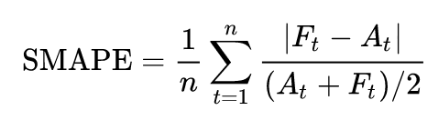

In [7]:
def smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 0.1) * 100)

In [8]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)

In [9]:
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    summ = tf.abs(y_true) + tf.abs(y_pred) + epsilon
    smape = tf.reduce_mean(200 * tf.abs(y_pred - y_true) / summ)
    return smape

## Model Selection

In [10]:
X_train_seq, y_train_seq = create_sequences(X_train, y_train, 1)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, 1)

In [11]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_seq.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

opt = keras.optimizers.Adam(1e-5)
model.compile(loss=smape_loss, optimizer=opt)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,665 (139.32 KB)

 Trainable params: 35,665 (139.32 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

I0000 00:00:1719623907.227646     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [13]:
y_pred = model.predict(X_test_seq)

smape_lstm = smape(y_test_seq, y_pred.mean(axis=1).flatten())
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred.mean(axis=1).flatten()))
mae_lstm = mean_absolute_error(y_test_seq, y_pred.mean(axis=1).flatten())
r2_lstm = r2_score(y_test_seq, y_pred.mean(axis=1).flatten())

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [14]:
regressors = []
regressors.append(("Linear Regression", LinearRegression()))
regressors.append(("Random Forest", RandomForestRegressor(random_state=random_state)))
regressors.append(("XGBoost (AE)", XGBRegressor(random_state=random_state, verbose=-1, objective='reg:absoluteerror')))
regressors.append(("XGBoost (SE)", XGBRegressor(random_state=random_state, verbose=-1)))

results = []
results.append(("LSTM", rmse_lstm, mae_lstm, r2_lstm, smape_lstm))

for name, reg in regressors:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    smape_score = smape(y_test, y_pred)
    mse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    r2_score_value = r2_score(y_test, y_pred)
    
    results.append((name, mse_score, mae_score, r2_score_value, smape_score))
    
results_df = pd.DataFrame(results, columns=["Algorithm", "RMSE", "MAE", "R²", "SMAPE"])
results_df

,Algorithm,RMSE,MAE,R²,SMAPE
0,LSTM,13.267825,7.421870,-0.069593,48.606126
1,Linear Regression,11.298094,7.584804,0.224323,49.666334
2,Random Forest,9.445501,5.972396,0.457849,40.197155
3,XGBoost (AE),9.622778,5.676192,0.437307,38.492745
4,XGBoost (SE),9.391797,6.034848,0.463996,41.617070


XGBoost dengan learning objective absolute error memiliki metric terbagus pada SMAPE dan MAE. Ada kemungkinan karena data terdapat beberapa nilai ekstem sehingga penalti pada RMSE bertambah cukup signifikan.

Oleh karena itu akan digunakan XGBoost (AE). Namun, LSTM akan kita benchmark lebih lanjut juga karena ada kemungkinan 1 time step (1 jam) kurang untuk menangkap relasi fitur sebenarnya.

## Time Steps

In [23]:
time_intervals = [3, 6, 12, 24, 24*3, 24*7]  

results = []
results.append(("XGB-0 Jam", results_df.iloc[3][1], results_df.iloc[3][2], results_df.iloc[3][3], results_df.iloc[3][4]))

for time_step in time_intervals:
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_step)
    
    # XGB menerima input 2D array, oleh karena itu kita flatten
    X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_test_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)
    
    model = XGBRegressor(random_state=random_state, objective='reg:absoluteerror')
    model.fit(X_train_flat, y_train_seq, verbose=False)
    
    y_pred_seq = model.predict(X_test_flat)
    
    smape_score = smape(y_test_seq, y_pred_seq)
    rmse_score = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
    mae_score = mean_absolute_error(y_test_seq, y_pred_seq)
    r2_score_value = r2_score(y_test_seq, y_pred_seq)
    
    results.append((f"XGB-{time_step} Jam", rmse_score, mae_score, r2_score_value, smape_score))

In [24]:
results.append(("LSTM-1 Jam", results_df.iloc[0][1], results_df.iloc[0][2], results_df.iloc[0][3], results_df.iloc[0][4]))

for time_step in time_intervals:
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_step)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(time_step, X_train_seq.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    opt = keras.optimizers.Adam(1e-5)
    model.compile(loss=smape_loss, optimizer=opt)
    
    model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)
    
    y_pred_seq = model.predict(X_test_seq).mean(axis=1).flatten()
    
    valid_idx = ~np.isnan(y_pred_seq)
    y_test_seq = y_test_seq[valid_idx]
    y_pred_seq = y_pred_seq[valid_idx]
    
    if len(y_test_seq) > 0:
        smape_score = smape(y_test_seq, y_pred_seq)
        rmse_score = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
        mae_score = mean_absolute_error(y_test_seq, y_pred_seq)
        r2_score_value = r2_score(y_test_seq, y_pred_seq)
        
        results.append((f"LSTM-{time_step} Jam", rmse_score, mae_score, r2_score_value, smape_score))
    else:
        print(f"No valid predictions for time_step {time_step}, skipping metrics calculation.")
        results.append((f"LSTM-{time_step} Jam", np.nan, np.nan, np.nan, np.nan))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [25]:
results_df = pd.DataFrame(results, columns=["Model-Time Step", "RMSE", "MAE", "R²", "SMAPE"])
results_df

,Model-Time Step,RMSE,MAE,R²,SMAPE
0,XGB-0 Jam,9.622778e+00,5.676192e+00,4.373072e-01,38.492745
1,XGB-3 Jam,1.227863e+01,7.049465e+00,8.399430e-02,45.776023
2,XGB-6 Jam,1.209477e+01,6.865667e+00,1.114391e-01,44.765481
3,XGB-12 Jam,1.211711e+01,6.913394e+00,1.089735e-01,45.237686
4,XGB-24 Jam,1.202294e+01,6.818276e+00,1.240288e-01,44.671468
5,XGB-72 Jam,1.212663e+01,6.871640e+00,1.115718e-01,44.466417
6,XGB-168 Jam,1.232596e+01,7.019906e+00,8.913654e-02,44.919695
7,LSTM-1 Jam,1.326782e+01,7.421870e+00,-6.959271e-02,48.606126
8,LSTM-3 Jam,1.296277e+01,7.246912e+00,-2.092511e-02,47.292854
9,LSTM-6 Jam,1.711408e+01,9.494013e+00,-7.790931e-01,57.728166


Performa model tanpa time step yang lebih baik dibandingkan performa menggunakan time step. Dapat kita buat asumsi bahwa inklusi data sebelumnya menimbulkan noise atau menambah kompleksitas yang sulit untuk ditangkap model. Performa model LSTM mendukung asumsi ini. Evaluation metric secara keseluruhan lebih buruk, yang kemungkinan karena model meng-overgeneralisasi fluktuasi atau pola temporal yang tidak relevan pada data.

## Hyperparameter Tuning

In [26]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 0, 1),
    }

    model = XGBRegressor(**param, objective='reg:absoluteerror', random_state=random_state)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    
    smape_score = smape(y_test, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    r2_score_value = r2_score(y_test, y_pred)
    
    trial.set_user_attr('smape', smape_score)
    trial.set_user_attr('rmse', rmse_score)
    trial.set_user_attr('mae', mae_score)
    trial.set_user_attr('r2', r2_score_value)
    
    return smape_score

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best parameters: {study.best_params}")
print(f'Best trial SMAPE: {study.best_trial.user_attrs["smape"]}')
print(f'Best trial RMSE: {study.best_trial.user_attrs["rmse"]}')
print(f'Best trial MAE: {study.best_trial.user_attrs["mae"]}')
print(f'Best trial R²: {study.best_trial.user_attrs["r2"]}')

[I 2024-06-29 01:57:17,311] A new study created in memory with name: no-name-e5068be9-9230-49dd-b513-43e54633bfed
[I 2024-06-29 01:57:19,006] Trial 0 finished with value: 37.68874456058317 and parameters: {'n_estimators': 274, 'learning_rate': 0.09821363898910934, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.580479834993695, 'colsample_bytree': 0.9222517987287039, 'alpha': 0.3513787631193681, 'lambda': 0.9481229816298866}. Best is trial 0 with value: 37.68874456058317.
[I 2024-06-29 01:57:19,870] Trial 1 finished with value: 38.044935522562334 and parameters: {'n_estimators': 163, 'learning_rate': 0.17092821391740654, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.972697443254058, 'colsample_bytree': 0.7657604345187636, 'alpha': 0.5175596016906062, 'lambda': 0.9115333268039387}. Best is trial 0 with value: 37.68874456058317.
[I 2024-06-29 01:57:20,966] Trial 2 finished with value: 38.815090195654165 and parameters: {'n_estimators': 268, 'learning_rate': 0.2733512428694

Best parameters: {'n_estimators': 285, 'learning_rate': 0.07000036538325966, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.566833353799025, 'colsample_bytree': 0.9724450047679658, 'alpha': 0.3386725243333994, 'lambda': 0.5692566677681892}
Best trial SMAPE: 36.943337270504294
Best trial RMSE: 9.393333358373765
Best trial MAE: 5.486492301847139
Best trial R²: 0.46382092611458847


## Time Series Cross Validation

In [28]:
tscv = TimeSeriesSplit(n_splits=splits)

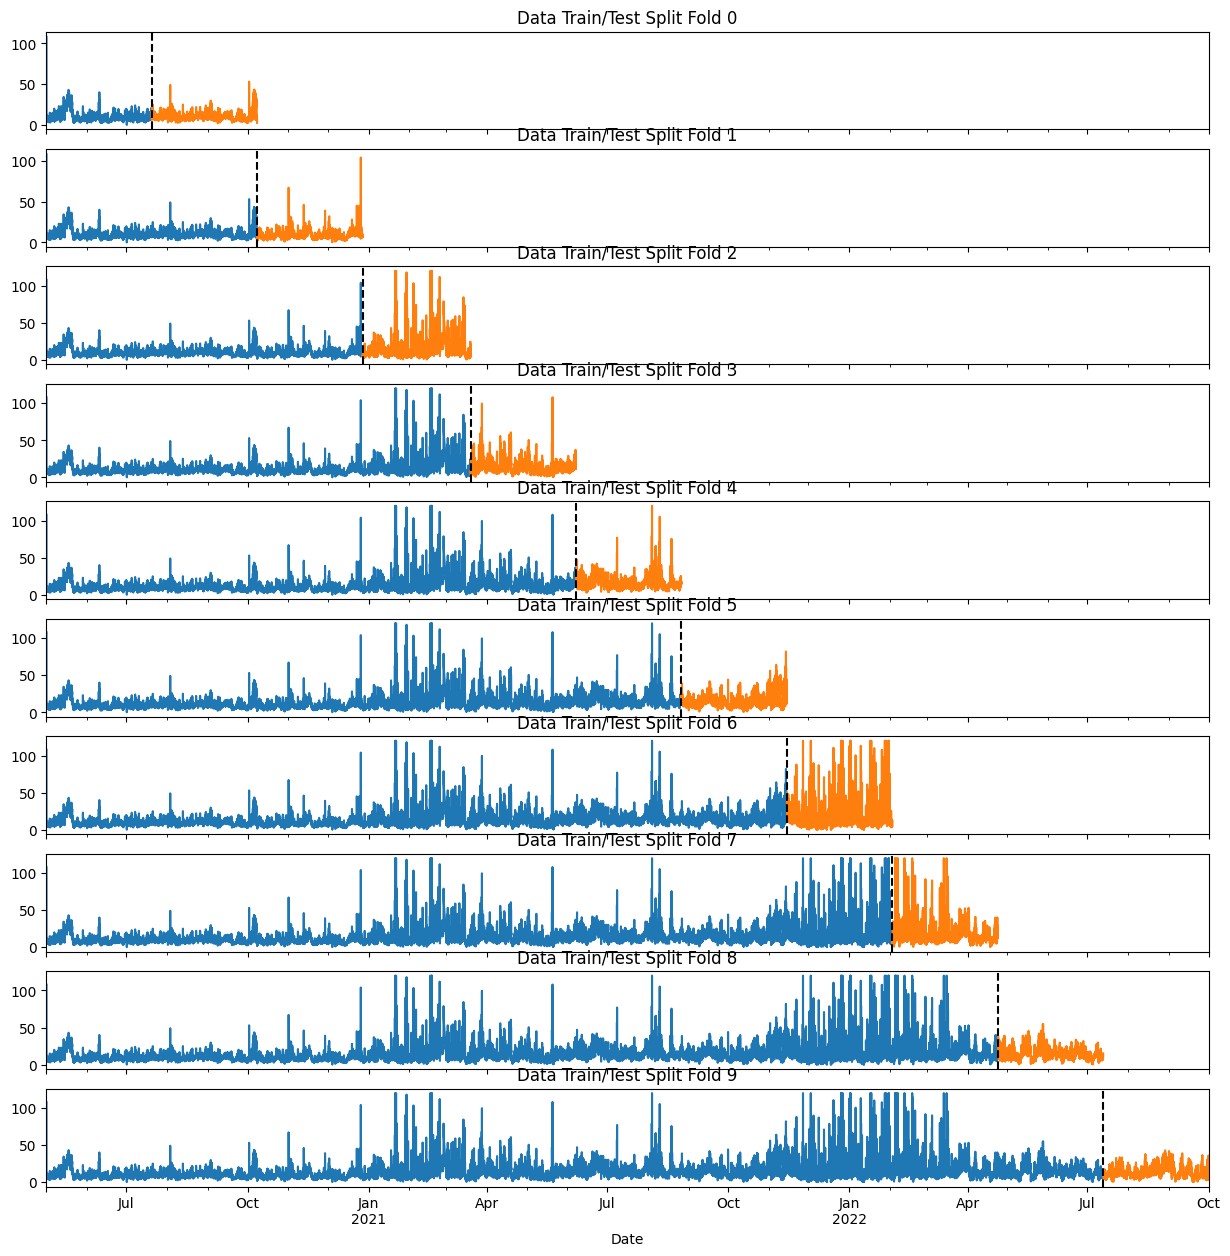

In [29]:
fig, axs = plt.subplots(splits, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tscv.split(train):
    train_temp = train.iloc[train_idx]
    test_temp = train.iloc[val_idx]
    train_temp['PM2.5'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test_temp['PM2.5'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test_temp.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Model akan di evaluasi dengan melatihnya dalam setiap fold data diatas, dimana setiap fold meningkatkan set train dan memvalidasi pada periode waktu berikutnya. Hal ini akan membantu kita dalam menilai seberapa bagus model menggeneralisasi data dari waktu ke waktu.

In [30]:
smape_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# X = df.drop(['station_name', 'code','id', 'PM10', 'PM2.5'], axis=1)
# y = df['PM2.5']
test_preds = np.zeros(len(test))

for fold,(train_index, val_index) in enumerate(tscv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = XGBRegressor(**study.best_params, random_state=random_state, objective='reg:absoluteerror')
    model.fit(X_train_cv, y_train_cv, verbose=False)
    
    y_pred = model.predict(X_test_cv)

    smape_score = smape(y_test_cv, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_test_cv, y_pred))
    mae_score = mean_absolute_error(y_test_cv, y_pred)
    r2_score_value = r2_score(y_test_cv, y_pred)
    
    smape_scores.append(smape_score)
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)
    r2_scores.append(r2_score_value)
    
    test_preds += model.predict(X_test)
    
    joblib.dump(model, f'model_xgboost_fold_{fold+1}.joblib')
    
    print(f"Fold {fold+1}:")
    print(f'SMAPE: {smape_score}')
    print(f'RMSE: {rmse_score}')
    print(f'MAE: {mae_score}')
    print(f'R²: {r2_score_value}')
    print('---')

mean_smape = np.mean(smape_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)

print("Mean SMAPE =", mean_smape)
print("Mean RMSE =", mean_rmse)
print("Mean MAE =", mean_mae)
print("Mean R² =", mean_r2)

Fold 1:
SMAPE: 24.818179517422912
RMSE: 4.366264041885949
MAE: 2.7004664078729506
R²: 0.36664047157870305
---
Fold 2:
SMAPE: 35.48193387836609
RMSE: 5.044423486282781
MAE: 3.3433579112588334
R²: 0.05299604325848628
---
Fold 3:
SMAPE: 43.78137714926681
RMSE: 12.514274904521944
MAE: 6.390560318468371
R²: 0.06044448769973354
---
Fold 4:
SMAPE: 38.267738378144855
RMSE: 7.835194256751768
MAE: 5.08525437601694
R²: 0.177584907570135
---
Fold 5:
SMAPE: 30.63429206907216
RMSE: 8.477306895943554
MAE: 5.155708822236475
R²: 0.08854527771034848
---
Fold 6:
SMAPE: 34.80614802968635
RMSE: 7.597919423220777
MAE: 5.071920408272769
R²: 0.272454418094887
---
Fold 7:
SMAPE: 43.95556565172469
RMSE: 15.915780910502868
MAE: 8.028141375678283
R²: 0.2906550400883321
---
Fold 8:
SMAPE: 34.29469201679536
RMSE: 10.374041419737951
MAE: 5.913433738872424
R²: 0.47299263747897446
---
Fold 9:
SMAPE: 30.36505294638914
RMSE: 5.766387988266658
MAE: 4.133435436555523
R²: 0.34473789660798715
---
Fold 10:
SMAPE: 30.91818697

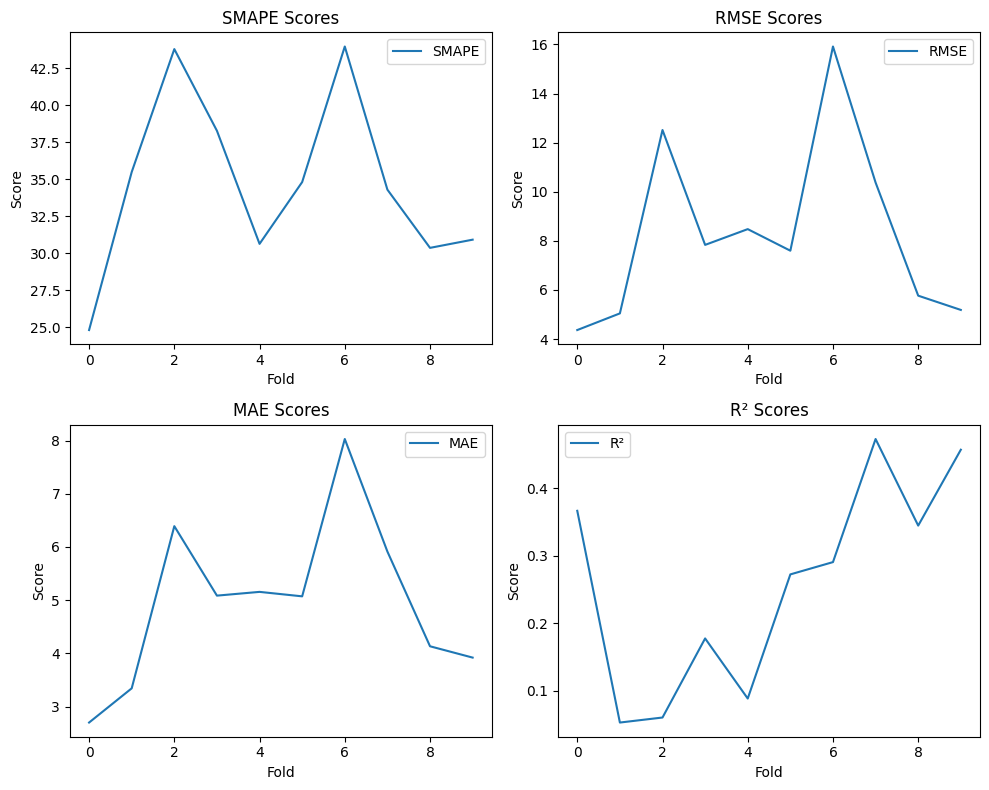

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(smape_scores, label='SMAPE')
axs[0, 0].set_title('SMAPE Scores')
axs[0, 0].set_xlabel('Fold')
axs[0, 0].set_ylabel('Score')
axs[0, 0].legend()

axs[0, 1].plot(rmse_scores, label='RMSE')
axs[0, 1].set_title('RMSE Scores')
axs[0, 1].set_xlabel('Fold')
axs[0, 1].set_ylabel('Score')
axs[0, 1].legend()

axs[1, 0].plot(mae_scores, label='MAE')
axs[1, 0].set_title('MAE Scores')
axs[1, 0].set_xlabel('Fold')
axs[1, 0].set_ylabel('Score')
axs[1, 0].legend()

axs[1, 1].plot(r2_scores, label='R²')
axs[1, 1].set_title('R² Scores')
axs[1, 1].set_xlabel('Fold')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

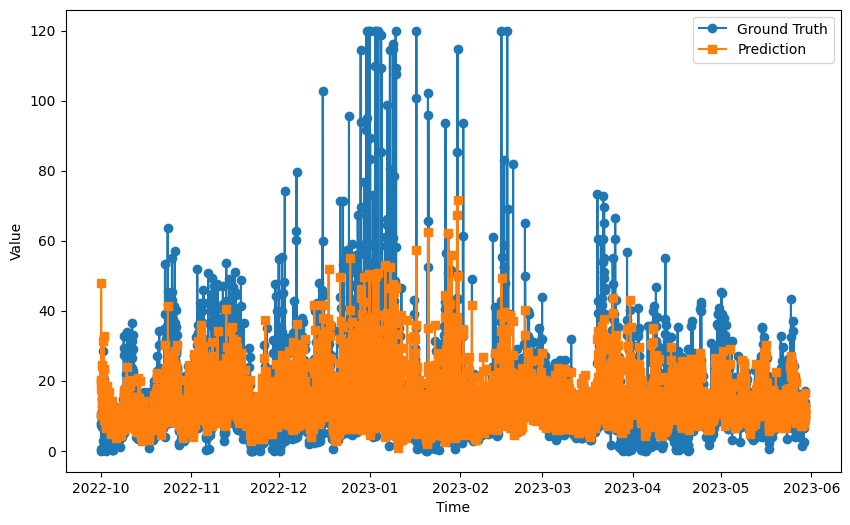

In [32]:
model = XGBRegressor(random_state=random_state, objective='reg:absoluteerror')
model.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, 'o-', label=f'Ground Truth')
plt.plot(y_test.index, model.predict(X_test), 's-', label=f'Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

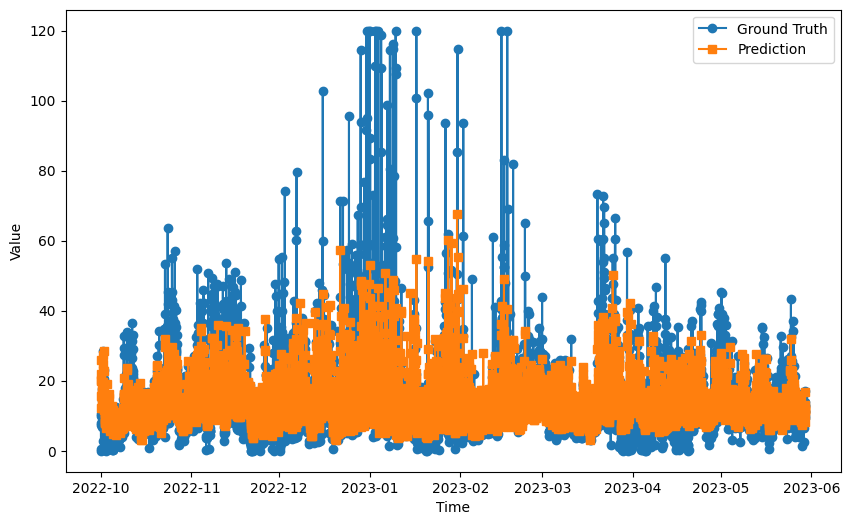

In [33]:
model = XGBRegressor(**study.best_params, random_state=random_state, objective='reg:absoluteerror')
model.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, 'o-', label=f'Ground Truth')
plt.plot(y_test.index, model.predict(X_test), 's-', label=f'Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

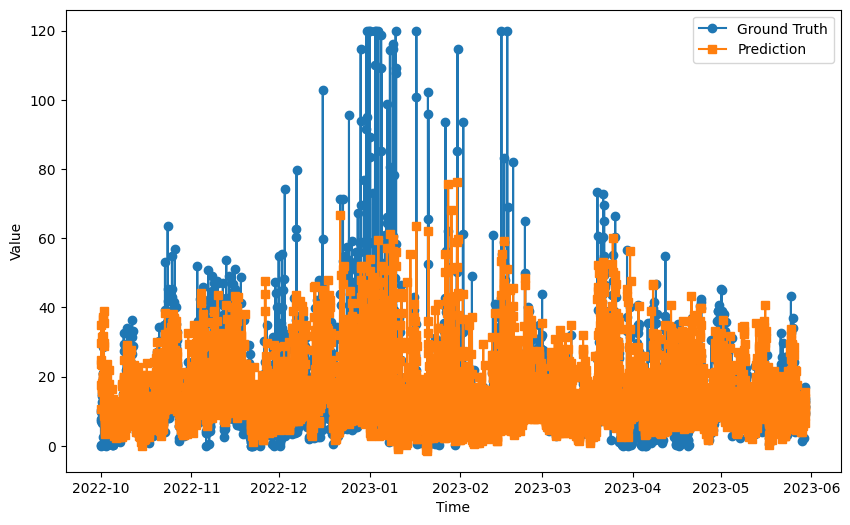

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, 'o-', label=f'Ground Truth')
plt.plot(y_test.index, test_preds/5-10, 's-', label=f'Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Memprediksi dengan bagging membantu sedikit dalam memprediksi nilai ekstem

## Same Station

Hasil analisis geospasial pada data geografis stasiun membawa pada suatu kesimpulan: bahwa lokasi
stasiun berpengaruh terhadap pembacaan rerata konsentrasi PM2.5. Secara spesifik, stasiun yang
ditempatkan dekat relatif terhadap pusat kota cenderung memperoleh pembacaan rerata konsentrasi
PM2.5 yang lebih tinggi. 

Di sisi lain, metode sampling yang digunakan pada penelitian ini berfokus untuk memperoleh data yang
representatif terhadap Athena (i.e. ketimbang suatu wilayah di pusat Kota Athena), sehingga data 
yang digunakan pada fase analisis dan training menggunakan sampling dari seluruh stasiun yang
disediakan.

Pada kasus analisis time series, terdapat trade-off yang menarik: sementara kita memperoleh data yang
lebih representatif untuk dianalisis, bagian besar dari forecasting data time series adalah mengambil
suatu kejadian ${t_{n-1} ... t_{n-m}}$ untuk memprediksi kejadian $t$. Pada kasus PM2.5, konsentrasi
$t$ dapat dipengaruhi oleh konsentrasi PM2.5 hingga beberapa hari sebelumnya, berdasarkan fakta bahwa
PM2.5 dapat bertahan di udara hingga tujuh hari lamanya (tergantung pada kecepatan angin dan lainnya).
Hal ini tentu saja tidak berlaku jika kejadian sebelum $t$ diambil dari tempat dengan statistik sampel
yang berbeda.

Berdasarkan fakta ini, kami mengambil suatu hipotesis: algoritma pembelajaran yang memanfaatkan
fitur lag (e.g. LSTM) dapat dioutperform oleh, misalnya, algoritma ensemble learning yang mengabaikan
lag. Hal ini terbukti pada kasus yang sebelumnya dipraktikkan.

In [35]:
ath0 = data[data['station_name'] == 'ATH-ENVICARE-0']
df_ath0 = ath0.groupby(pd.Grouper(freq='h')).first()
df_ath0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26976 entries, 2020-05-01 00:00:00 to 2023-05-29 23:00:00
Freq: h
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude             26976 non-null  float64
 1   Longitude            26976 non-null  float64
 2   station_name         26976 non-null  object 
 3   Wind-Speed (U)       26928 non-null  float64
 4   Wind-Speed (V)       26928 non-null  float64
 5   Dewpoint Temp        26928 non-null  float64
 6   Soil Temp            26928 non-null  float64
 7   Total Percipitation  26928 non-null  float64
 8   Vegitation (High)    26928 non-null  float64
 9   Vegitation (Low)     26928 non-null  float64
 10  Temp                 26928 non-null  float64
 11  Relative Humidity    26928 non-null  float64
 12  PM10                 26976 non-null  float64
 13  PM2.5                26976 non-null  float64
 14  NO2                  26928 non-null  float6

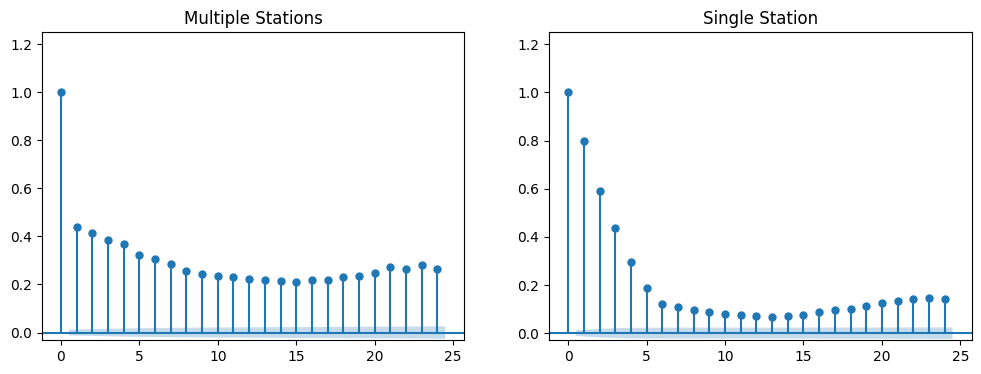

In [36]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))
plot_acf(df['PM2.5'], lags=24, ax=ax[0], title='Multiple Stations', auto_ylims=True)
plot_acf(df_ath0['PM2.5'], lags=24, ax=ax[1], title='Single Station', auto_ylims=True)

plt.show()

Plot autocorrelation memberikan insight tambahan terhadap hipotesis yang diambil: correlation score
pada data single station cenderung dapat dipertahankan hingga nilai lag yang sedikit lebih tinggi.
Efek terlihat jauh lebih jelas pada stasiun dengan pembacaan rerata konsentrasi PM2.5 yang tinggi.

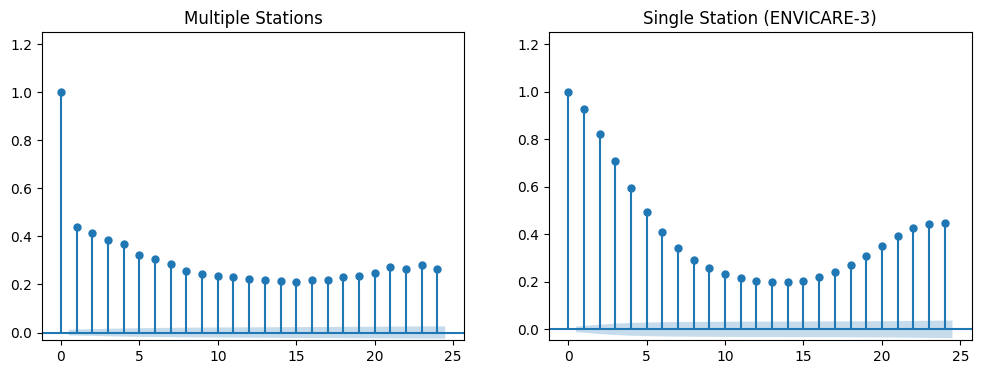

In [37]:
ath3 = data[data['station_name'] == 'ATH-ENVICARE-3']
df_ath3 = ath3.groupby(pd.Grouper(freq='h')).first()

fig, ax = plt.subplots(1, 2,figsize=(12,4))
plot_acf(df['PM2.5'], lags=24, ax=ax[0], title='Multiple Stations', auto_ylims=True)
plot_acf(df_ath3['PM2.5'], lags=24, ax=ax[1], title='Single Station (ENVICARE-3)', auto_ylims=True)

plt.show()

Lantas, bagaimana performa model yang dilatih pada data single station?

In [38]:
df_ath0 = preprocess(df_ath0)
df_ath0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26928 entries, 2020-05-01 00:00:00 to 2023-05-29 23:00:00
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude             26928 non-null  float64
 1   Longitude            26928 non-null  float64
 2   station_name         26928 non-null  object 
 3   Wind-Speed (U)       26928 non-null  float64
 4   Wind-Speed (V)       26928 non-null  float64
 5   Dewpoint Temp        26928 non-null  float64
 6   Soil Temp            26928 non-null  float64
 7   Total Percipitation  26928 non-null  float64
 8   Vegitation (High)    26928 non-null  float64
 9   Vegitation (Low)     26928 non-null  float64
 10  Temp                 26928 non-null  float64
 11  Relative Humidity    26928 non-null  float64
 12  PM10                 26928 non-null  float64
 13  PM2.5                26928 non-null  float64
 14  NO2                  26928 non-null  float64
 15  O

In [39]:
train = df_ath0.loc[df_ath0.index <= '2022-10-01']
test = df_ath0.loc[df_ath0.index > '2022-10-01']

X_train = train.drop(['Latitude', 'Longitude', 'station_name', 'code','id', 'PM10', 'PM2.5'], axis=1)
y_train = train['PM2.5']

X_test = test.drop(['Latitude', 'Longitude', 'station_name', 'code','id', 'PM10', 'PM2.5'], axis=1)
y_test = test['PM2.5']

random_state = 42
splits = 10

In [40]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 0, 1),
    }

    model = XGBRegressor(**param, objective='reg:absoluteerror', random_state=random_state)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    
    smape_score = smape(y_test, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    r2_score_value = r2_score(y_test, y_pred)
    
    trial.set_user_attr('smape', smape_score)
    trial.set_user_attr('rmse', rmse_score)
    trial.set_user_attr('mae', mae_score)
    trial.set_user_attr('r2', r2_score_value)
    
    return smape_score

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best parameters: {study.best_params}")
print(f'Best trial SMAPE: {study.best_trial.user_attrs["smape"]}')
print(f'Best trial RMSE: {study.best_trial.user_attrs["rmse"]}')
print(f'Best trial MAE: {study.best_trial.user_attrs["mae"]}')
print(f'Best trial R²: {study.best_trial.user_attrs["r2"]}')

[I 2024-06-29 02:02:19,309] A new study created in memory with name: no-name-8e801bd9-d656-4259-9bf4-495eac81439f
[I 2024-06-29 02:02:21,213] Trial 0 finished with value: 42.793339842280055 and parameters: {'n_estimators': 289, 'learning_rate': 0.23095406210517563, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.9193763264043768, 'colsample_bytree': 0.742980391428467, 'alpha': 0.11435603729277277, 'lambda': 0.179747053096718}. Best is trial 0 with value: 42.793339842280055.
[I 2024-06-29 02:02:21,818] Trial 1 finished with value: 42.516716234305854 and parameters: {'n_estimators': 141, 'learning_rate': 0.2681290136427975, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8106360608206056, 'colsample_bytree': 0.9817309144188767, 'alpha': 0.021417692007688505, 'lambda': 0.40977667450682875}. Best is trial 1 with value: 42.516716234305854.
[I 2024-06-29 02:02:23,668] Trial 2 finished with value: 42.04301317199612 and parameters: {'n_estimators': 213, 'learning_rate': 0.18119897

Best parameters: {'n_estimators': 269, 'learning_rate': 0.03356200763951371, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8172543799520711, 'colsample_bytree': 0.7128202021816264, 'alpha': 0.5359916103885616, 'lambda': 0.9294612681340889}
Best trial SMAPE: 39.848733098532364
Best trial RMSE: 16.677185824900807
Best trial MAE: 10.07113841080548
Best trial R²: 0.3163670165472452


In [47]:
tscv = TimeSeriesSplit(n_splits=splits)

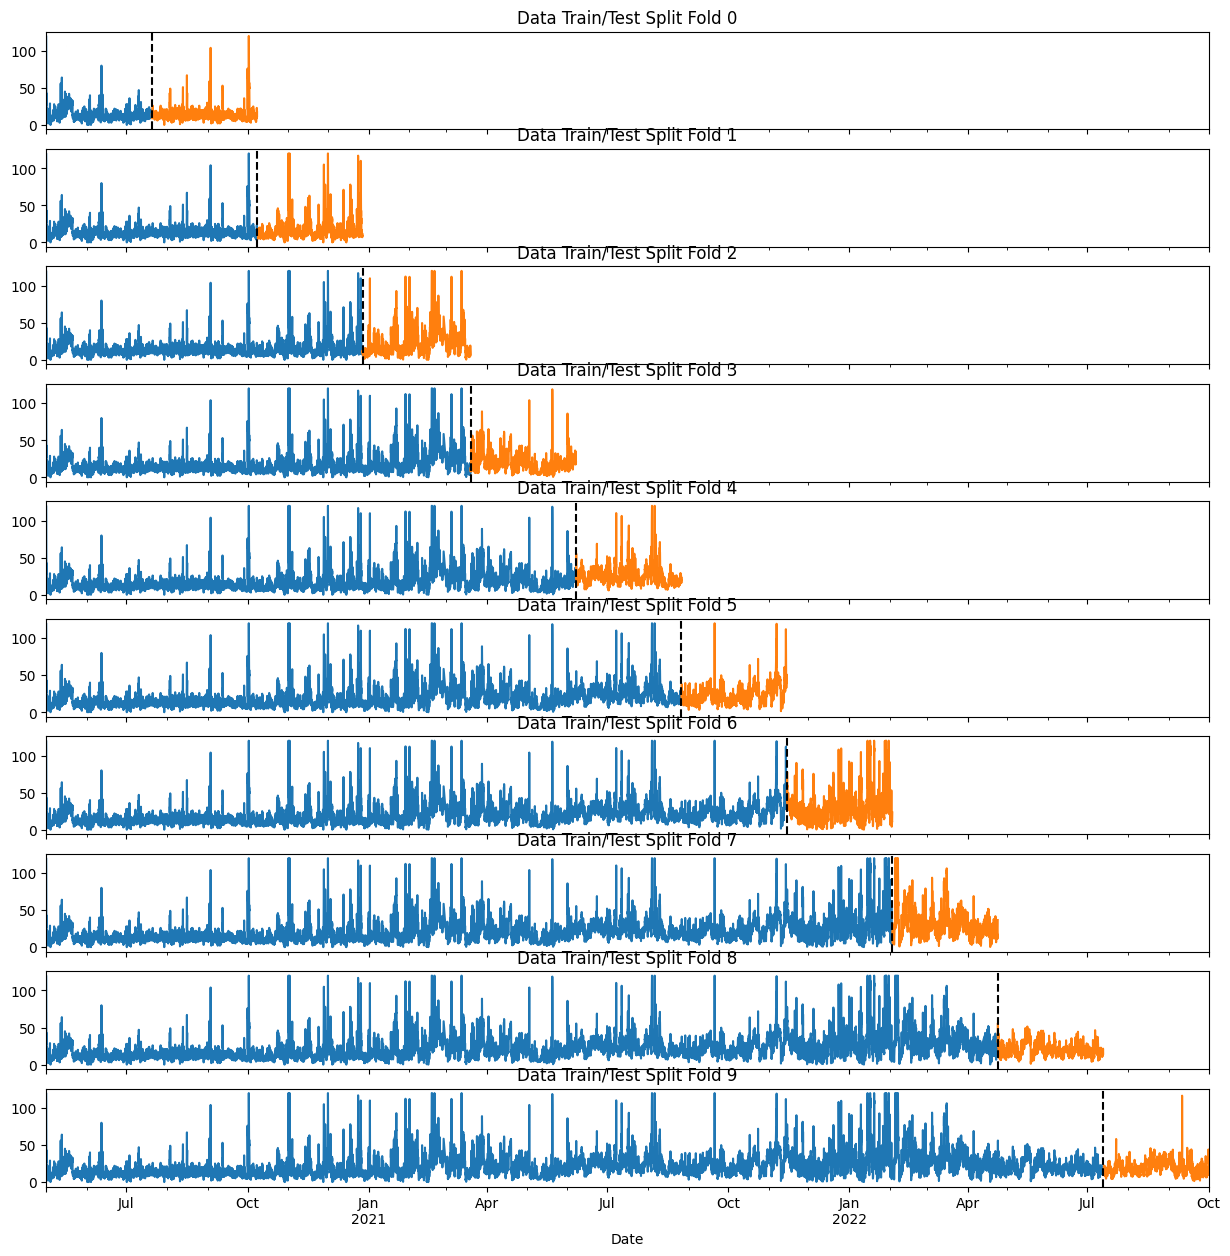

In [48]:
fig, axs = plt.subplots(splits, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tscv.split(train):
    train_temp = train.iloc[train_idx]
    test_temp = train.iloc[val_idx]
    train_temp['PM2.5'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test_temp['PM2.5'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test_temp.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [49]:
smape_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

test_preds = np.zeros(len(test))

for fold,(train_index, val_index) in enumerate(tscv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = XGBRegressor(**study.best_params, random_state=random_state, objective='reg:absoluteerror')
    model.fit(X_train_cv, y_train_cv, verbose=False)

    y_pred = model.predict(X_test_cv)

    smape_score = smape(y_test_cv, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_test_cv, y_pred))
    mae_score = mean_absolute_error(y_test_cv, y_pred)
    r2_score_value = r2_score(y_test_cv, y_pred)
    
    smape_scores.append(smape_score)
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)
    r2_scores.append(r2_score_value)
    
    test_preds += model.predict(X_test)
    
    print(f"Fold {fold+1}:")
    print(f'SMAPE: {smape_score}')
    print(f'RMSE: {rmse_score}')
    print(f'MAE: {mae_score}')
    print(f'R²: {r2_score_value}')
    print('---')

mean_smape = np.mean(smape_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)

print("Mean SMAPE =", mean_smape)
print("Mean RMSE =", mean_rmse)
print("Mean MAE =", mean_mae)
print("Mean R² =", mean_r2)

Fold 1:
SMAPE: 30.391654828219306
RMSE: 8.059794847931977
MAE: 4.5102558663442816
R²: 0.18261196872273922
---
Fold 2:
SMAPE: 39.847958528970274
RMSE: 13.131446341549985
MAE: 7.087197281394868
R²: 0.23744496680313554
---
Fold 3:
SMAPE: 53.02086829962287
RMSE: 17.856105193999824
MAE: 11.644829751891072
R²: 0.10039918234105705
---
Fold 4:
SMAPE: 46.26494076686159
RMSE: 12.027554815440515
MAE: 8.49431265067054
R²: 0.14859378429132686
---
Fold 5:
SMAPE: 40.27090865638504
RMSE: 15.115075476617141
MAE: 9.940206685678307
R²: -0.4294931567149367
---
Fold 6:
SMAPE: 38.77019556952489
RMSE: 12.664583058217506
MAE: 8.698315034128068
R²: 0.02250989159916772
---
Fold 7:
SMAPE: 46.125996682465875
RMSE: 15.918818527679697
MAE: 11.48217188275371
R²: 0.38260854899070174
---
Fold 8:
SMAPE: 32.95811871796171
RMSE: 11.89683494325468
MAE: 8.594354993950414
R²: 0.5390871009651317
---
Fold 9:
SMAPE: 32.15668399093918
RMSE: 7.948917227852017
MAE: 6.259423921355725
R²: 0.17040593624472233
---
Fold 10:
SMAPE: 31.

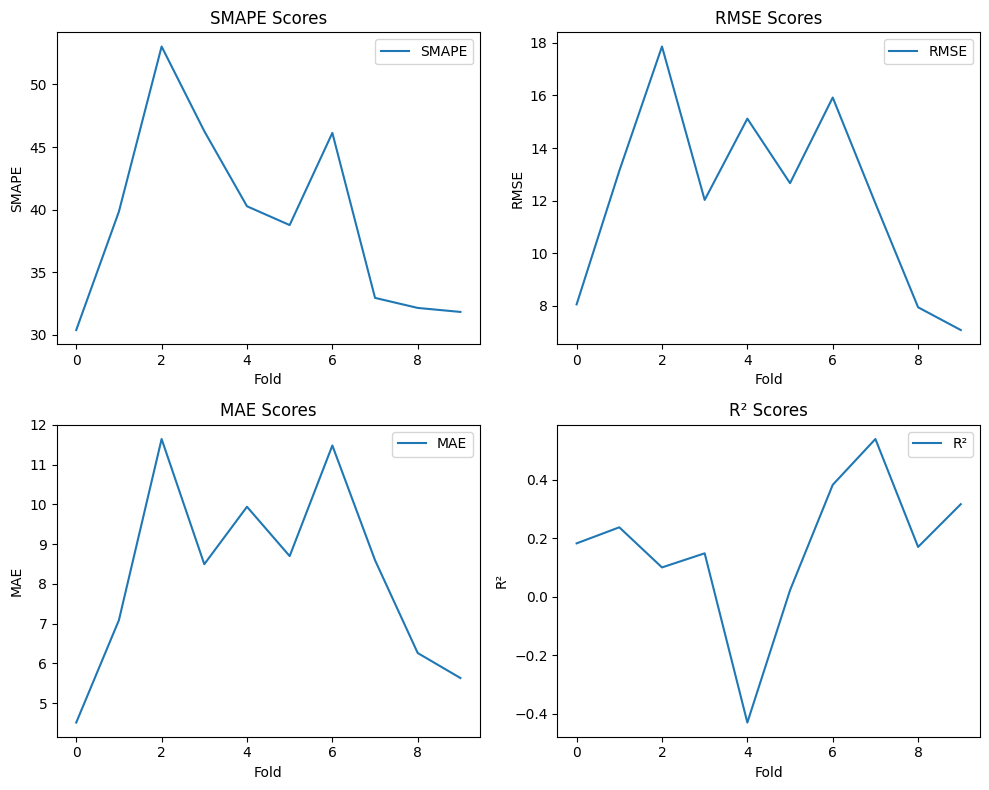

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(smape_scores, label="SMAPE")
axs[0, 0].set_title("SMAPE Scores")
axs[0, 0].set_xlabel("Fold")
axs[0, 0].set_ylabel("SMAPE")
axs[0, 0].legend()

axs[0, 1].plot(rmse_scores, label="RMSE")
axs[0, 1].set_title("RMSE Scores")
axs[0, 1].set_xlabel("Fold")
axs[0, 1].set_ylabel("RMSE")
axs[0, 1].legend()

axs[1, 0].plot(mae_scores, label="MAE")
axs[1, 0].set_title("MAE Scores")
axs[1, 0].set_xlabel("Fold")
axs[1, 0].set_ylabel("MAE")
axs[1, 0].legend()

axs[1, 1].plot(r2_scores, label="R²")
axs[1, 1].set_title("R² Scores")
axs[1, 1].set_xlabel("Fold")
axs[1, 1].set_ylabel("R²")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

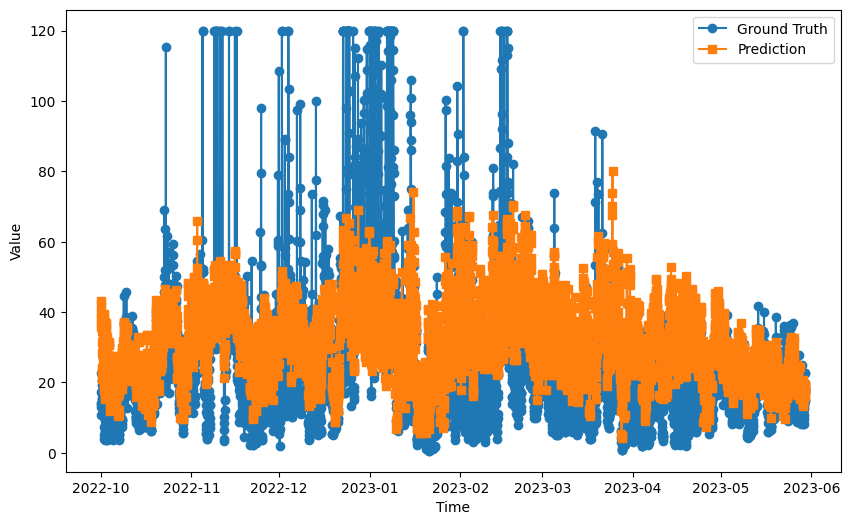

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, 'o-', label=f'Ground Truth')
plt.plot(y_test.index, test_preds/5-10, 's-', label=f'Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

****